In [ ]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [ ]:
!ls track

driving_log.csv  IMG


In [ ]:
!pip3 install imgaug

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import os
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from imgaug import augmenters as iaa
import random
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import ntpath
import cv2
import h5py

Using TensorFlow backend.


In [ ]:
datadir = 'track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [ ]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


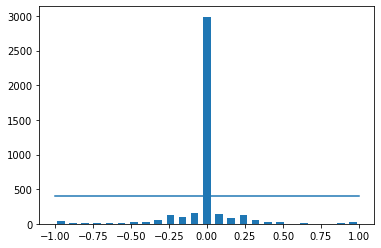

In [ ]:
num_bins =25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+bins[1:])*0.5
print(bins)
plt.bar(center,hist,width = 0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total data: 4053
removed: 2590
remaining: 1463


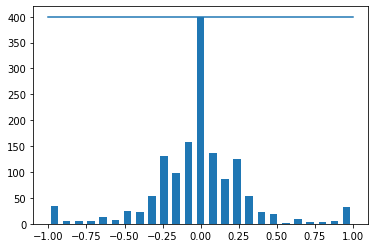

In [ ]:

print('total data:',len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i]>= bins[j] and data['steering'][i]<bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:] 
  remove_list.extend(list_)

print('removed:',len(remove_list))
data.drop(data.index[remove_list],inplace= True)
print('remaining:',len(data))

hist, _ = np.histogram(data['steering'],num_bins)
plt.bar(center,hist,width = 0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

  

  

In [ ]:
def load_img_steering(datadir,df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths,steerings

image_paths, steerings = load_img_steering(datadir+'/IMG',data)


In [ ]:
X_train, X_valid, y_train,y_valid = train_test_split(image_paths,steerings,test_size = 0.2,random_state = 6)
print('Training samples: {}\nValidation samples:{}'.format(len(X_train),len(X_valid)))

Training samples: 1170
Validation samples:293


Text(0.5, 1.0, 'Validation Set')

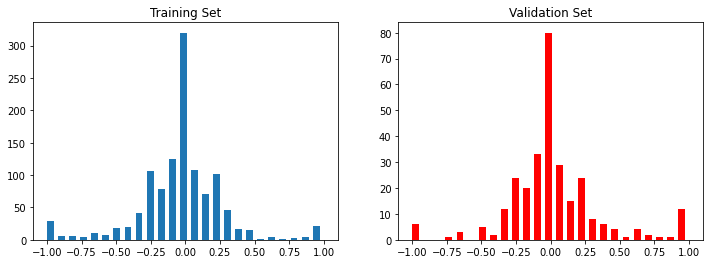

In [ ]:
fig,axes = plt.subplots(1,2,figsize= (12,4))
axes[0].hist(y_train,num_bins,width=0.05)
axes[0].set_title('Training Set')
axes[1].hist(y_valid,num_bins,width=0.05,color='red')
axes[1].set_title('Validation Set')

In [ ]:
def zoom(image):
   zoom = iaa.Affine(scale=(1,1.3))
   image = zoom.augment_image(image)
   return image
   

Text(0.5, 1.0, 'Original')

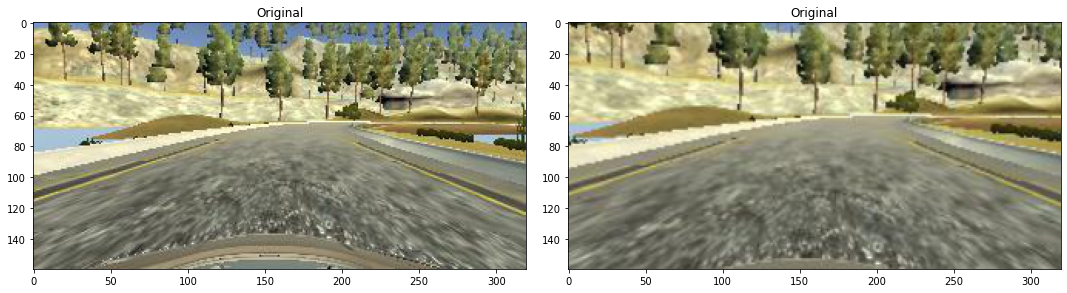

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))

fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original')

axs[1].imshow(zoomed_image)
axs[1].set_title('Original')


In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent = {'x':(-0.1,0.1),'y':(-0.1,0.1)})
  image =pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned')

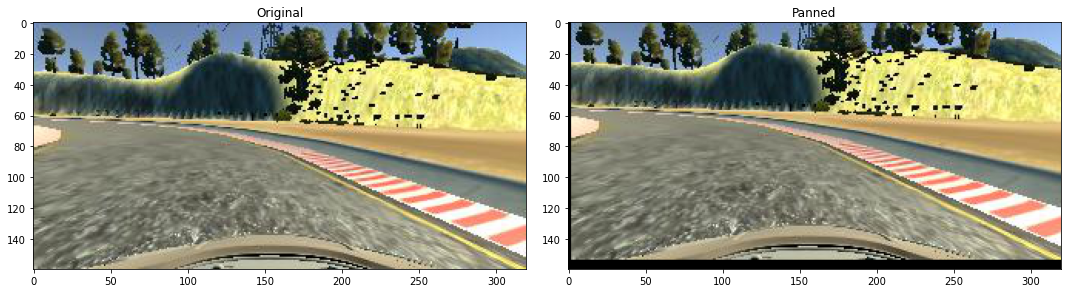

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))

fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original')

axs[1].imshow(panned_image)
axs[1].set_title('Panned')

In [ ]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image
  

Text(0.5, 1.0, 'Bright alt')

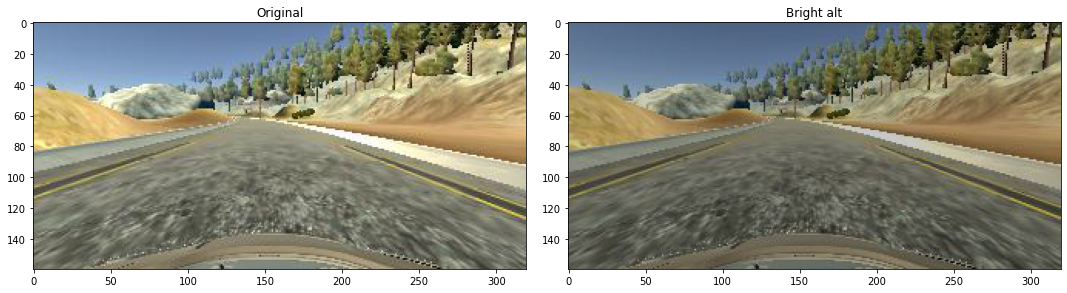

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))

fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Bright alt')

In [ ]:
def img_random_flip(image,steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image,steering_angle

Text(0.5, 1.0, 'Flipped-Steering Angle0.2405379')

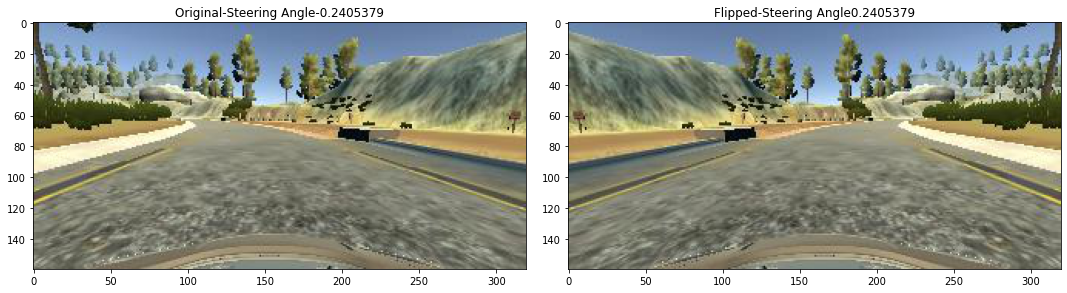

In [ ]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image,flipped_steering_angle = img_random_flip(original_image,steering_angle)

fig,axs = plt.subplots(1,2,figsize=(15,10))

fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original-'+'Steering Angle'+str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped-'+'Steering Angle'+str(flipped_steering_angle))

In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle


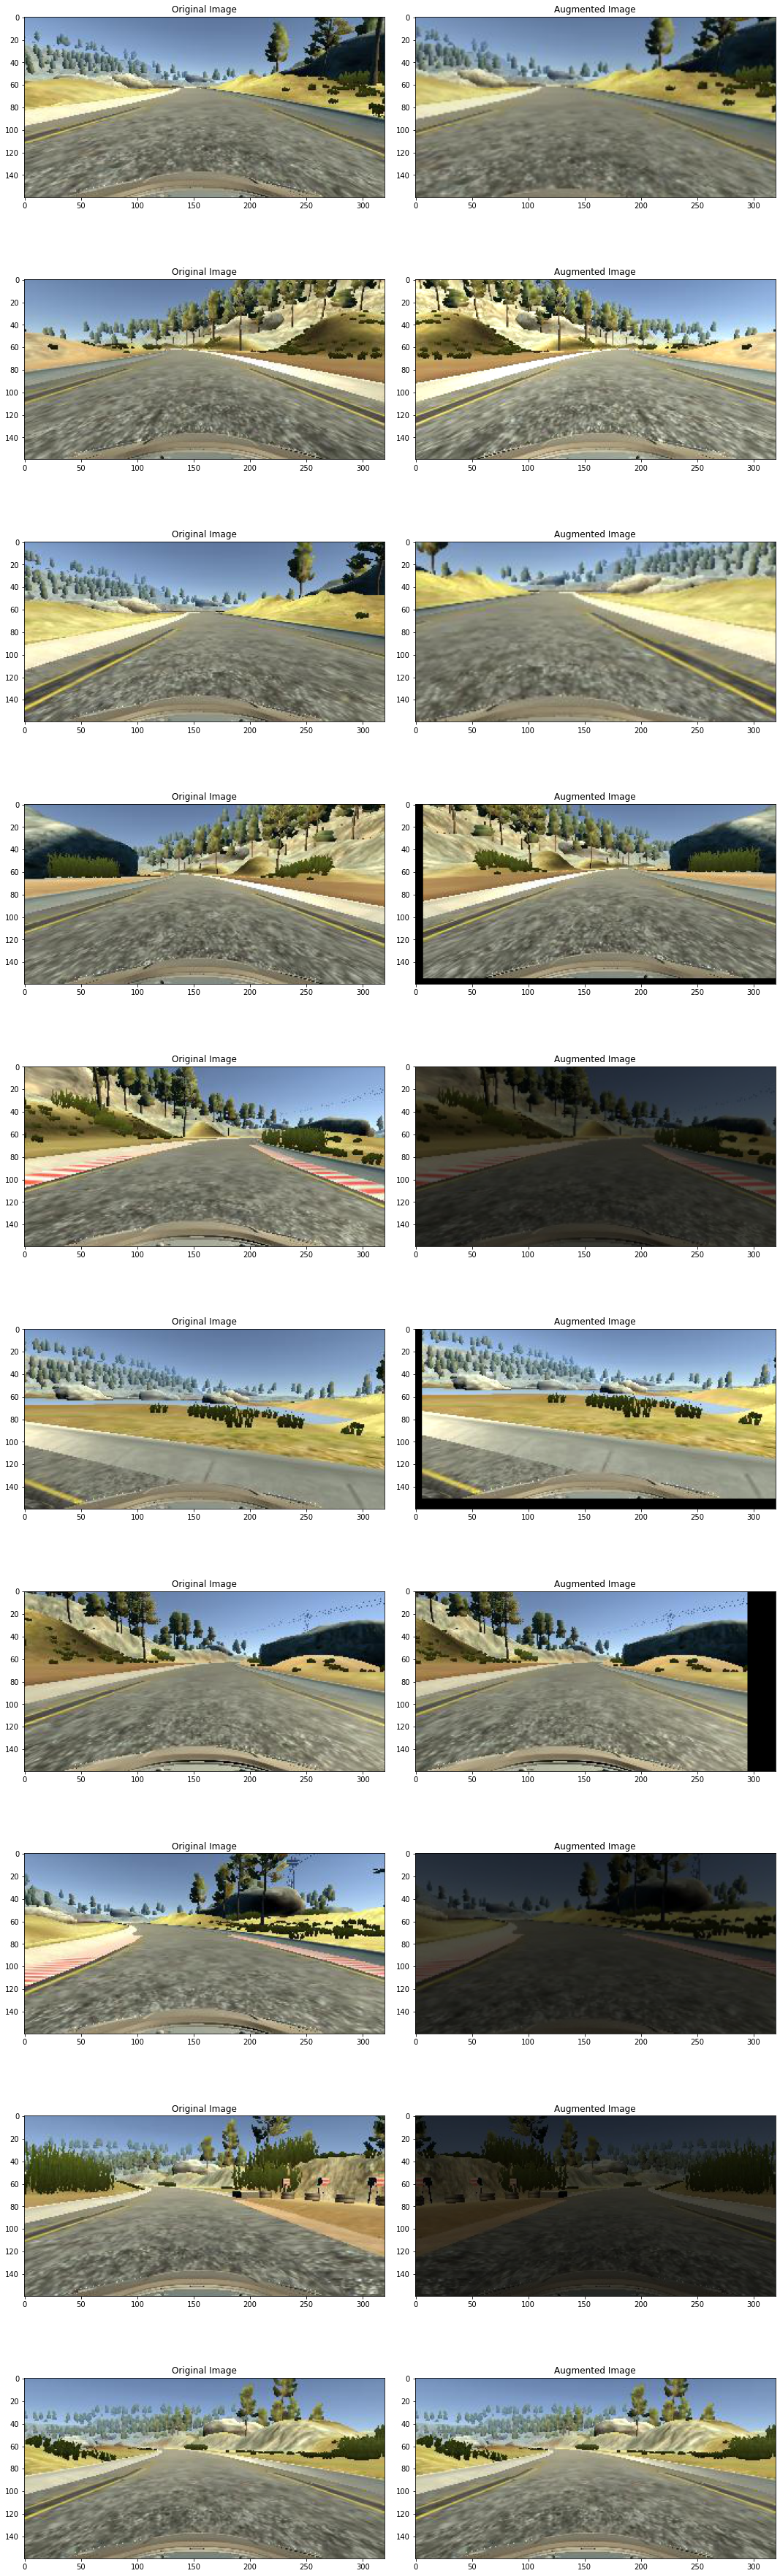

In [ ]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [ ]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img =cv2.GaussianBlur(img,(3,3),0)
  img= cv2.resize(img,(200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed')

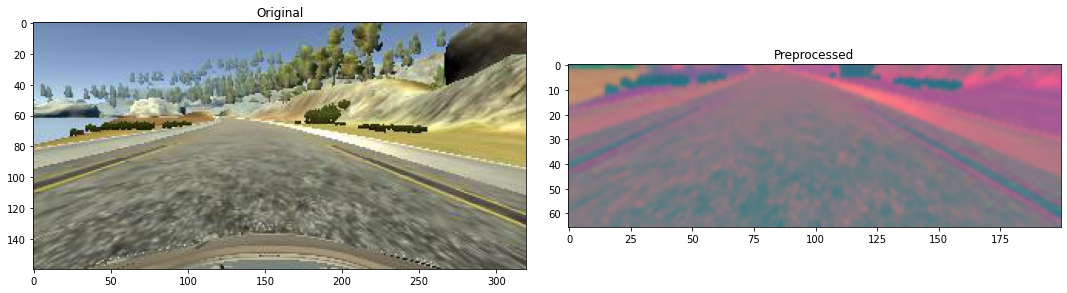

In [ ]:
image = image_paths[100]
original = mpimg.imread(image)
preprocessed = img_preprocess(original)

fig,axes = plt.subplots(1,2,figsize= (15,10))
fig.tight_layout()

axes[0].imshow(original)
axes[0].set_title('Original')

axes[1].imshow(preprocessed)
axes[1].set_title('Preprocessed')


In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 





Text(0.5, 1.0, 'Validation Image')

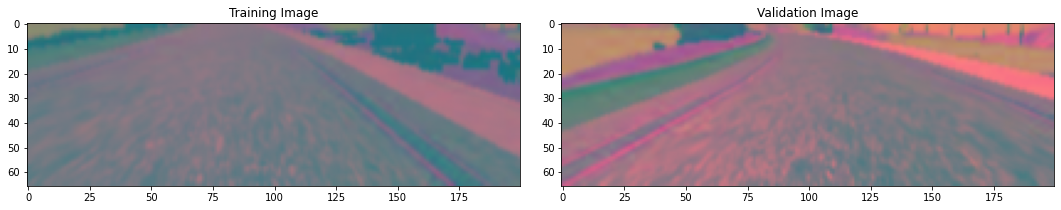

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [ ]:
#X_train = np.array(list(map(img_preprocess,X_train)))
#X_valid = np.array(list(map(img_preprocess,X_valid)))


In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size = (5,5),strides= (2,2), input_shape =(66,200,3) ,activation='elu'))
  model.add(Conv2D(36,kernel_size=(5,5),strides= (2,2),activation='elu'))
  model.add(Conv2D(48,kernel_size=(5,5),strides= (2,2),activation='elu'))
  model.add(Conv2D(64,kernel_size=(3,3),activation='elu'))
  model.add(Conv2D(64,kernel_size=(3,3),activation='elu'))
  
  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(50,activation='elu'))
 # model.add(Dropout(0.5))
  model.add(Dense(10,activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(Adam(lr=1e-4),loss='mse')
  return model
  



In [ ]:
model = nvidia_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

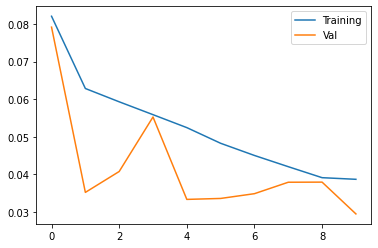

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Val'])

In [ ]:
model.save('model.h5')

In [ ]:
print(keras.__version__)

2.3.1
